In [16]:
from pprint import pprint
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)

In [4]:
MAX_MEMORY = "30G"

spark = SparkSession \
    .builder \
    .appName("parse-wikipedia-sql-dumps") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config('spark.driver.maxResultSize', MAX_MEMORY) \
    .config('spark.ui.showConsoleProgress', 'false') \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/28 20:07:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/10/28 20:07:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
stringency_dtype={
    'CountryName': "category",
    'CountryCode': "category",
    'RegionName': "category",
    "RegionCode": "category",
    "Jurisdiction": "category",
    "Date": "string",
    "C1_School closing": "float",
    "C1_Flag": "Int32",
    'C1_Notes': "string",
    'C2_Workplace closing': "float",
    'C2_Flag': "Int32",
    'C2_Notes': "string",
    'C3_Cancel public events': "float",
    'C3_Flag': "Int32",
    'C3_Notes': "string",
    'C4_Restrictions on gatherings': "float",
    'C4_Flag': "Int32",
    'C4_Notes': "string",
    'C5_Close public transport': "float",
    'C5_Flag': "Int32",
    'C5_Notes': "string",
    'C6_Stay at home requirements': "float",
    'C6_Flag': "Int32",
    'C6_Notes': "string",
    'C7_Restrictions on internal movement': "float",
    'C7_Flag': "Int32",
    'C7_Notes': "string",
    'C8_International travel controls': "float",
    'C8_Notes': "string",
    'E1_Income support': "float",
    'E1_Flag': "Int32",
    'E1_Notes': "string",
    'E2_Debt/contract relief': "float",
    'E2_Notes': "string",
    'E3_Fiscal measures': "float",
    'E3_Notes': "string",
    'E4_International support': "float",
    'E4_Notes': "string",
    'H1_Publicinformation campaigns': "float",
    'H1_Flag': "Int32",
    'H1_Notes': "string",
    'H2_Testing policy': "float",
    'H2_Notes': "string",
    'H3_Contact tracing': "float",
    'H3_Notes': "string",
    'H4_Emergency investment in healthcare': "float",
    'H4_Notes': "string",
    'H5_Investment in vaccines': "float",
    'H5_Notes': "string",
    'H6_Facial Coverings': "float",
    'H6_Flag': "Int32",
    'H6_Notes': "string",
    'H7_Vaccination policy': "float",
    'H7_Flag': "Int32",
    'H7_Notes': "string",
    'H8_Protection of elderly people': "float",
    'H8_Flag': "Int32",
    'H8_Notes': "string",
    'M1_Wildcard': "float",
    'M1_Notes': "string",
    'ConfirmedCases': "float",
    'ConfirmedDeaths': "float",
    'StringencyIndex': "float",
    'StringencyIndexForDisplay': "float",
    'StringencyLegacyIndex': "float",
    'StringencyLegacyIndexForDisplay': "float",
    'GovernmentResponseIndex': "float",
    'GovernmentResponseIndexForDisplay': "float",
    'ContainmentHealthIndex': "float",
    'ContainmentHealthIndexForDisplay': "float",
    'EconomicSupportIndex': "float",
    'EconomicSupportIndexForDisplay': "float",
}

stringency2020 = pd.read_csv(
    "../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes_2020.csv", dtype=stringency_dtype)
    # "data/OxCGRT_withnotes_2020.csv", dtype=stringency_dtype)
stringency2021 = pd.read_csv(
    "../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes_2021.csv", dtype=stringency_dtype)
    # "data/OxCGRT_withnotes_2021.csv", dtype=stringency_dtype)

# print(vaccines.columns.tolist())
vaccines = pd.read_csv("../nvme/oxcgrt-covid-policy-tracker/OxCGRT_vaccines_full.csv")
# vaccines = pd.read_csv("data/OxCGRT_vaccines_full.csv")
languages = pd.read_csv("./data/languages.csv", index_col="code")

def clean_stringency(df):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("/", "_") for c in df.columns})
    df["c1_flag"] = df["c1_flag"].fillna(0).astype("bool")
    df["date"] = pd.to_datetime(df["date"])
    return df

def clean_vaccines(df):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("/", "_") for c in df.columns})
    df["date"] = pd.to_datetime(df["date"].astype("string"))
    return df

stringency2020 = clean_stringency(stringency2020)
stringency2021 = clean_stringency(stringency2021)
stringency = pd.concat([stringency2020, stringency2021])
vaccines = clean_vaccines(vaccines)

In [13]:
stringency.to_csv("../nvme/stringency.csv", index=False)
vaccines.to_csv("../nvme/vaccines.csv", index=False)
stringency.head()
vaccines.head()

,countryname,countrycode,date,v1_vaccine_prioritisation_(summary),v1_0-4_yrs_infants,v1_5-15_yrs_young_people,v1_airport_border_airline_staff,v1_at_risk_16-19_yrs,v1_at_risk_20-24_yrs,v1_at_risk_25-29_yrs,...,"v3_other_'high_contact'_professions_groups_(taxi_drivers,_security_guards)",v3_people_living_with_a_vulnerable_shielding_person_or_other_priority_group,v3_police__first_responders,v3_pregnant_people,v3_primary_and_secondary_school_students,v3_religious_spiritual_leaders,v3_residents_in_an_elderly_care_home_,v3_staff_working_in_an_elderly_care_home,v3_tertiary_education_students,v3_notes
0,Australia,AUS,2020-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,AUS,2020-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,AUS,2020-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,AUS,2020-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,AUS,2020-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


root
 |-- countryname: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- regionname: string (nullable = true)
 |-- regioncode: string (nullable = true)
 |-- jurisdiction: string (nullable = true)
 |-- date: string (nullable = true)
 |-- c1_school_closing: double (nullable = true)
 |-- c1_flag: boolean (nullable = true)
 |-- c1_notes: string (nullable = true)
 |-- c2_workplace_closing: string (nullable = true)
 |-- c2_flag: string (nullable = true)
 |-- c2_notes: string (nullable = true)
 |-- c3_cancel_public_events: string (nullable = true)
 |-- c3_flag: string (nullable = true)
 |-- c3_notes: string (nullable = true)
 |-- c4_restrictions_on_gatherings: string (nullable = true)
 |-- c4_flag: string (nullable = true)
 |-- c4_notes: string (nullable = true)
 |-- c5_close_public_transport: string (nullable = true)
 |-- c5_flag: string (nullable = true)
 |-- c5_notes: string (nullable = true)
 |-- c6_stay_at_home_requirements: string (nullable = true)
 |-- c6_flag: s

TypeError: unhashable type: 'numpy.ndarray'

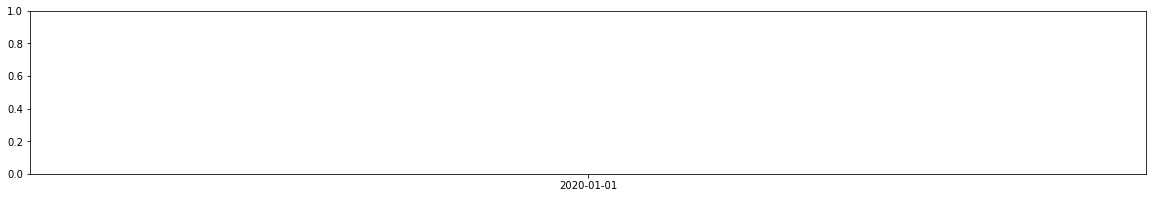

In [22]:
stringency_spark = spark.read.format("csv").options(header="true", inferSchema="true").load("../nvme/stringency.csv")
vaccines_spark = spark.read.format("csv").options(header="true", inferSchema="true").load("../nvme/vaccines.csv")
stringency_spark.printSchema()

stringency_spark.write.format("parquet").mode("overwrite").partitionBy("countryname").save("../nvme/stringency.parquet")
germany = stringency_spark.filter(F.col("countryname") == "Germany").select("date","stringencyindex").toPandas().set_index("date")
# germany = df.loc[df["countryname"] == "Germany", ["date", "stringencyindex"]].set_index("date")
print(germany.head())
print(germany.dtypes)
plt.plot(germany)
plt.title("Stringency index for Germany")
plt.xlabel("time")
plt.ylabel("stringency index")
plt.show()
# vaccines_spark.write.format("parquet").mode("overwrite").partitionBy("countryname").save("../nvme/vaccines.parquet")

In [104]:
# print(stringency.dtypes)
# print(stringency["stringencyindex"].unique().tolist())
vaccines.head()
pprint(vaccines.columns.tolist())

['countryname',
 'countrycode',
 'date',
 'v1_vaccine_prioritisation_(summary)',
 'v1_0-4_yrs_infants',
 'v1_5-15_yrs_young_people',
 'v1_airport_border_airline_staff',
 'v1_at_risk_16-19_yrs',
 'v1_at_risk_20-24_yrs',
 'v1_at_risk_25-29_yrs',
 'v1_at_risk_30-34_yrs',
 'v1_at_risk_35-39_yrs',
 'v1_at_risk_40-44_yrs',
 'v1_at_risk_45-49_yrs',
 'v1_at_risk_50-54_yrs',
 'v1_at_risk_55-59_yrs',
 'v1_at_risk_60-64_yrs',
 'v1_at_risk_65-69_yrs',
 'v1_at_risk_70-74_yrs',
 'v1_at_risk_75-79_yrs',
 'v1_at_risk_80+_yrs',
 'v1_clinically_vulnerable_chronic_illness_significant_underlying_health_condition_(excluding_elderly_and_disabled)',
 'v1_crowded_communal_living_conditions_(dormitories_for_migrant_workers,_temporary_accommodation)',
 'v1_disabled_people',
 'v1_educators',
 'v1_ethnic_minorities',
 'v1_factory_workers',
 'v1_frontline_retail_workers',
 'v1_frontline_essential_workers_(when_subcategories_not_specified)',
 'v1_general_16-19_yrs',
 'v1_general_20-24_yrs',
 'v1_general_25-29_yrs',

            stringencyindex
date                       
2020-01-01              0.0
2020-01-02              0.0
2020-01-03              0.0
2020-01-04              0.0
2020-01-05              0.0


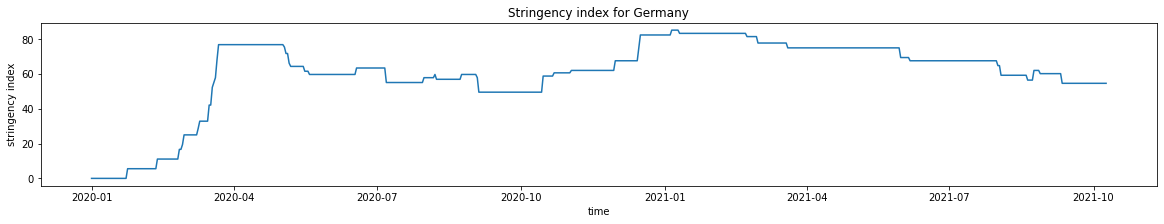

In [105]:
# plot the data for germany to get a feel
df = stringency
germany = df.loc[df["countryname"] == "Germany", ["date", "stringencyindex"]].set_index("date")
print(germany.head())
plt.plot(germany)
plt.title("Stringency index for Germany")
plt.xlabel("time")
plt.ylabel("stringency index")
plt.show()

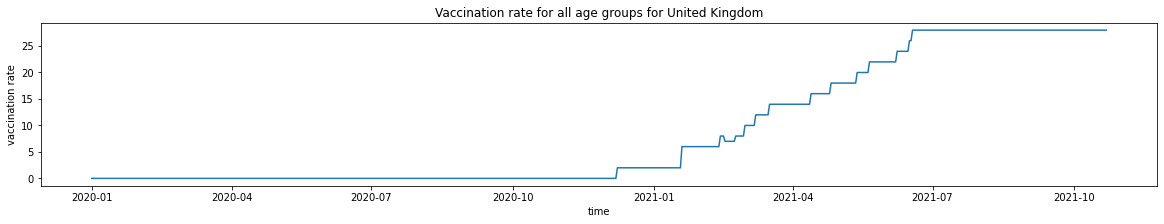

In [106]:
# plot the vaccination for germany to get a feel
df = vaccines
country = "Germany"
country = "United Kingdom"
age_groups = [
    'v3_general_16-19_yrs',
    'v3_general_20-24_yrs',
    'v3_general_25-29_yrs',
    'v3_general_30-34_yrs',
    'v3_general_35-39_yrs',
    'v3_general_40-44_yrs',
    'v3_general_45-49_yrs',
    'v3_general_50-54_yrs',
    'v3_general_55-59_yrs',
    'v3_general_60-64_yrs',
    'v3_general_65-69_yrs',
    'v3_general_70-74_yrs',
    'v3_general_75-79_yrs',
    'v3_general_80+_yrs',
]
germany = df.loc[df["countryname"] == country,:].copy()
germany["total"] = 0
for age in age_groups:
    germany["total"] += germany[age].fillna(0.0)
germany = germany[["date", "total"]].set_index("date")
plt.plot(germany)
plt.title("Vaccination rate for all age groups for %s" % country)
plt.xlabel("time")
plt.ylabel("vaccination rate")
plt.show()

In [107]:
if False:
        df = df.rename(columns={
            "CountryName": "country_name",
            'CountryCode': "country_code",
            'RegionName': "region_name",
            "RegionCode": "region_code",
            "Jurisdiction": "jurisdiction",
            "Date": "date",
            "C1_School closing": "c1_school_closing",
            "C1_Flag": "c1_flag",
            "C1_Notes": "c1_notes",
            "C2_Workplace closing": "c2_workplace_closing",
            "StringencyIndex": "stringency_index",
            "StringencyIndexForDisplay": "stringency_index_for_display",
            "StringencyLegacyIndex": "stringency_legacy_index",
            "StringencyLegacyIndexForDisplay": "stringency_legacy_index_for_display",
            "GovernmentResponseIndex": "government_response_index",
            "GovernmentResponseIndexForDisplay": "government_response_index_for_display",
            "ContainmentHealthIndex": "containment_health_index",
            "ContainmentHealthIndexForDisplay": "containment_health_index_for_display",
            "EconomicSupportIndex": "economic_support_index",
            "EconomicSupportIndexForDisplay": "economic_support_index_for_display",
        })

In [108]:
# ChangePoints stringency 2020

import json
from datetime import datetime
import ruptures as rpt
countries = ["Germany", "France", "Italy", "Netherlands", "Spain", "Sweden"]

def get_change_points(df, countries):
    results = {}
    for country in countries:
        subset = df.loc[df["countryname"] == country, ["date", "stringencyindex"]].set_index("date")
        
        algo = rpt.Pelt(model="rbf").fit(subset)
        change_index = algo.predict(pen=5)
        
        change_dates = [subset.iloc[index-1].name.strftime("%Y-%m-%d") for index in change_index]
        
        results[country] = change_dates
        
    return results



In [112]:
stringency_changepoints_2020 = get_change_points(stringency2020, countries)

stringency_changepoints_2021 = get_change_points(stringency2021, countries)

with open('stringency_changepoints_2020.json', 'w') as f:
    json.dump(stringency_changepoints_2020, f)
    
with open('stringency_changepoints_2021.json', 'w') as f:
    json.dump(stringency_changepoints_2021, f)

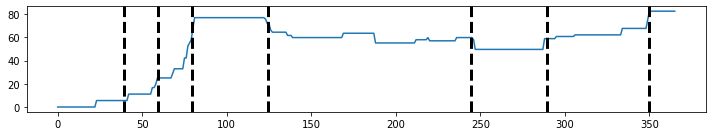

In [113]:
## Display: Germany 
def display_change_points(data, countryname):
    subset = data.loc[data["countryname"] == countryname, ["date", "stringencyindex"]].set_index("date")
    algo = rpt.Pelt(model="rbf").fit(subset)
    results = algo.predict(pen=5)
    rpt.display(subset, [], results)

display_change_points(stringency2020, "Germany")

In [94]:
subset = stringency2021.loc[stringency2021["countryname"] == "Germany", ["date", "stringencyindex"]].set_index("date")

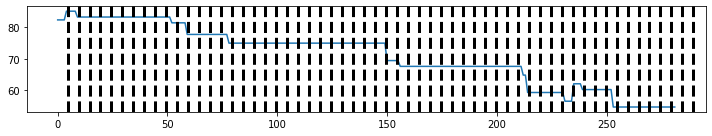

In [100]:
# plot the vaccination for germany to get a feel
df = vaccines
country = "Germany"
country = "United Kingdom"
age_groups = [
    'v3_general_16-19_yrs',
    'v3_general_20-24_yrs',
    'v3_general_25-29_yrs',
    'v3_general_30-34_yrs',
    'v3_general_35-39_yrs',
    'v3_general_40-44_yrs',
    'v3_general_45-49_yrs',
    'v3_general_50-54_yrs',
    'v3_general_55-59_yrs',
    'v3_general_60-64_yrs',
    'v3_general_65-69_yrs',
    'v3_general_70-74_yrs',
    'v3_general_75-79_yrs',
    'v3_general_80+_yrs',
]
def display_change_points_vacinnes(df, countryname):
    country = df.loc[df["countryname"] == countryname,:].copy()
    country["total"] = 0
    for age in age_groups:
        country["total"] += country[age].fillna(0.0)
    country = country[["date", "total"]].set_index("date")
    algo = rpt.Pelt(model="rbf").fit(subset)
    results = algo.predict(pen=5)
    rpt.display(subset, [], results)

display_change_points_vacinnes(df, "Germany")